In [1]:
import pykep as pk
import numpy as np

def planetary_distance(planet1, planet2, epoch):
    r1, _ = np.array(planet1.eph(epoch))
    r2, _ = np.array(planet2.eph(epoch))
    return np.linalg.norm(r1 - r2)

In [10]:
import pykep as pk
import numpy as np

def planetary_angle(planet1, planet2, epoch):
    r1, _ = np.array(planet1.eph(epoch))
    r2, _ = np.array(planet2.eph(epoch))

    r1_hat, r2_hat = r1 / np.linalg.norm(r1), r2 /np.linalg.norm(r2)
    return np.arccos(r1_hat.dot(r2_hat))

In [9]:
from astropy.time import Time
from astropy.units import Unit
from datetime import datetime
from poliastro.bodies import Sun
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit
import numpy as np

def _get_orbit(attractor, planet, epoch: Time) -> Orbit:
     return Orbit.from_ephem(attractor, Ephem.from_body(planet, epoch), epoch)

target = Mars
now = Time(datetime.utcnow(), scale='tdb')
orbit1, orbit2 = Orbit.from_sbdb('16 Psyche'), _get_orbit(Sun, target, now) # Orbit.from_sbdb('16 Psyche')

In [7]:
from poliastro.iod.izzo import lambert

def lambert_multirev(a, b, revs=0):
    # Get initial algorithm conditions
    k = a.attractor.k
    r_i = a.r
    r_f = b.r

    # Time of flight is solved by subtracting both orbit epochs
    tof = b.epoch - a.epoch

    # Compute all possible solutions to the Lambert transfer
    try:
        return [(v_i - a.v, b.v - v_f) for v_i, v_f in lambert(k, r_i, r_f, tof, M=revs)]
    except ValueError:
        return lambert_multirev(a, b, revs=revs - 1)

In [106]:
min(np.linalg.norm(dv1) for dv1, dv2 in lambert_multirev(orbit1, orbit2.propagate(5000.0), revs=10))

<Quantity 3.60606698 km / s>

In [14]:
from itertools import product
from poliastro.maneuver import Maneuver
import matplotlib.pyplot as plt
import numpy as np

days = Unit('d')
period = orbit1.period.to('d').value

@np.vectorize
def lambert_dv(t_prime: float, tof: float):
    t = t_prime * days
    
    launch = orbit1.propagate(t)
    arrival = orbit2.propagate(t + tof * days)

    revs = int(np.floor(tof / period))
    dv = min(np.linalg.norm(dv1) for dv1, dv2 in lambert_multirev(launch, arrival, revs=revs))
    # dv, _ = min(
    #     (
    #         (np.linalg.norm(dv1), np.linalg.norm(dv2))
    #         for dv1, dv2 in lambert_multirev(launch, arrival, revs=revs)
    #     ),
    #     key=lambda x: np.linalg.norm(x[0])
    # )
    return dv.value

X = np.arange(0.0, 1000.0, 5.0)
Y = np.arange(200.0, 7300.0, 5.0)

# points = [lambert_dv(x, y) for x, y in product(X, Y)]


X, Y = np.meshgrid(X, Y)
Z = lambert_dv(X, Y)

Text(0, 0.5, 'Impact velocity (km/s)')

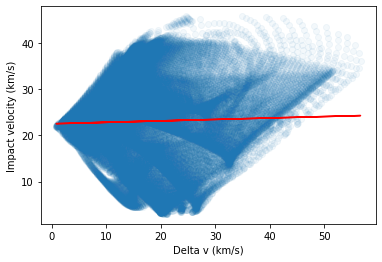

In [151]:
x = np.array([x for x, y in points])
y = np.array([y for x, y in points])
plt.scatter(x, y, alpha=0.05)

m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b, c='red')
plt.xlabel('Delta v (km/s)')
plt.ylabel('Impact velocity (km/s)')

In [150]:
x.min()

0.8130660400462602

In [11]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Surface(x=X, y=Y, z=Z)]
)
fig.update_layout(
    # title='Delta v from 2010 YD3 to Mars (km/s)',
    title='Delta v (km/s)',
    height=1000,
    width=1000,
    margin=dict(l=10, r=10, t=40, b=10),
    scene=dict(
        xaxis=dict(title='Launch date (days from now)'),
        yaxis=dict(title='Time of flight (days)'),
        # zaxis=dict(title='Delta v (km/s)')
        zaxis=dict(title='Delta v (km/s)')
    )
)
fig.show()

In [133]:
lambert_multirev(orbit1.propagate(1195.0), orbit2.propagate(1965.0), revs=5)

[(<Quantity [12.16803073, -5.26927273,  7.19251693] km / s>,
  <Quantity [-4.77848812,  8.53218475,  9.53621954] km / s>)]

In [12]:
x, y = divmod(np.argmin(Z), Z.shape[1])
x * 5, 200 + y * 5

(405, 640)

In [132]:
Z[x, y]

2.0733587070903883

In [13]:
np.min(Z)

2.6178255647156474

In [45]:
from astropy.time import Time
from astropy.units import Unit
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.plotting import OrbitPlotter3D

launch = Time(Time.now(), scale='tdb')
arrival = launch + 500.0

asteroid = Orbit.from_sbdb('2010 YD').change_plane(Planes.EARTH_EQUATOR)
mars0 = Orbit.from_ephem(Sun, Ephem.from_body(Mars, launch), launch)
mars_f = mars0.propagate(arrival)

plotter = OrbitPlotter3D(dark=True)
plotter.plot(asteroid, label='2010 YD at launch')
plotter.plot(mars0, label='Mars at launch')
plotter.plot(mars_f, label='Mars at arrival')

transfer0, transfer_f = asteroid.apply_maneuver(Maneuver.lambert(asteroid, mars_f), intermediate=True)
plotter.plot_trajectory(transfer0.sample(max_anomaly=mars_f.nu), color='gray', label='Transfer')

In [33]:
from pathfinder import search_asteroids_by_name

search_asteroids_by_name('2010 YD')

full_name       e      a      i      om       w      ma  \
spkid                                                                      
3554416          (2010 YD)  0.5379  2.043   0.44   94.13   39.72  206.53   
3555045         (2010 YD3)  0.5671  2.584  24.50  252.15  219.44  195.51   

              sigma_e       sigma_a   sigma_i  sigma_om   sigma_w  sigma_ma  \
spkid                                                                         
3554416  5.300000e-04  2.600000e-03  0.000230  0.016000  0.019000  2.500000   
3555045  2.500000e-07  2.200000e-07  0.000041  0.000072  0.000076  0.000098   

         diameter  diameter_sigma      epoch spec_T spec_B  
spkid                                                       
3554416     0.026            0.01  2459396.5   <NA>   <NA>  
3555045     0.755            0.25  2459396.5   <NA>   <NA>

In [31]:
asteroid.classical()

(<Quantity 2.0433801 AU>,
 <Quantity 0.53787341>,
 <Quantity 0.44084743 deg>,
 <Quantity 94.12768619 deg>,
 <Quantity 39.7218718 deg>,
 <Quantity -170.44197459 deg>)

In [28]:
orbit0.plane

<Planes.EARTH_ECLIPTIC: 'Earth mean Ecliptic and Equinox of epoch (J2000.0)'>

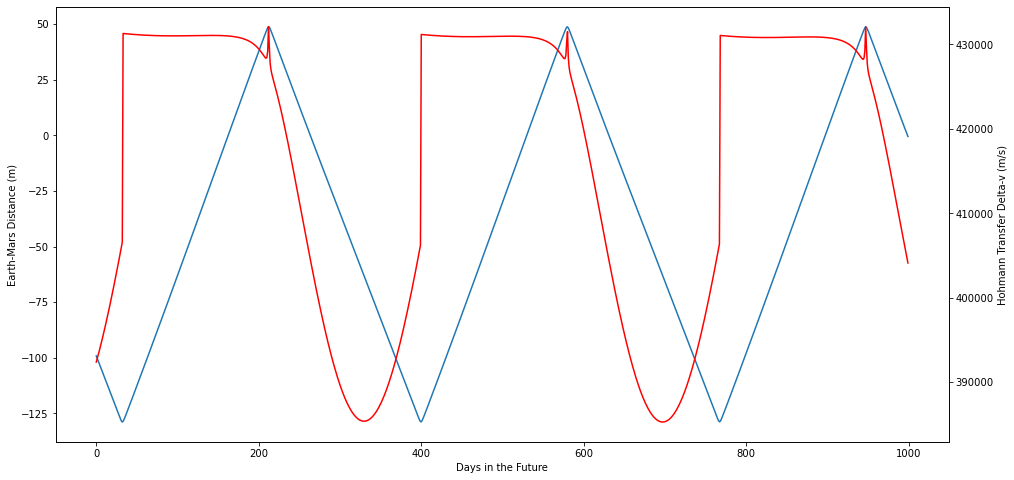

In [14]:
import matplotlib.pyplot as plt
from astropy.units import Time
from datetime import datetime
from poliastro.bodies import Earth
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit

now = Time(datetime.utcnow(), scale='tdb')
earth_ephem = Ephem.from_body(Earth, now)
mars_ephem = Ephem.from_body(Mars, now)


offset = 0
xlim = 1000

fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)

epochs = [pk.epoch(now.mjd2000 + x) for x in range(offset, xlim + offset)]
dists = [planetary_angle(earth, neptune, epoch) * (360 / (2 * np.pi)) - 129.99513640353416 for epoch in epochs]

ax1.set_xlabel("Days in the Future")
ax1.set_ylabel("Earth-Mars Distance (m)")
ax1.plot(list(range(xlim)), dists)

ax2 = ax1.twinx()

dvs = [hohmann_dv(earth, neptune, epoch, tof=250.0) for epoch in epochs]
ax2.set_ylabel("Hohmann Transfer Delta-v (m/s)")
ax2.plot(list(range(xlim)), dvs, color='red')

In [17]:
udp.pretty(pop.champion_x)

Total DV (m/s):  5870.74938557078
Dvs (m/s):  [3346.877824575315, 2523.8715609954643]
Tofs (days):  [342.0794560236768]


In [6]:
from pathfinder import get_asteroid_info, get_mars_crossers

info = get_asteroid_info()

Loading cached asteroid info from 'jpl-asteriod-info.csv'


In [16]:
info

full_name       e      a      i      om       w  \
spkid                                                                     
2000001         1 Ceres (A801 AA)  0.0784  2.766  10.59   80.27   73.74   
2000002        2 Pallas (A802 FA)  0.2298  2.774  34.90  172.92  310.44   
2000003          3 Juno (A804 RA)  0.2570  2.668  12.99  169.85  248.00   
2000004         4 Vesta (A807 FA)  0.0884  2.362   7.14  103.81  151.02   
2000005       5 Astraea (A845 XA)  0.1906  2.574   5.37  141.57  358.66   
...                           ...     ...    ...    ...     ...     ...   
3839175               (2019 AR40)  0.2448  2.744  13.47  302.97  253.65   
3839314                (2019 BY5)  0.2971  2.715  16.57  122.96  297.42   
3839472                (2019 BX6)  0.2430  2.679  16.72   38.98   26.09   
3839444                (2019 BB7)  0.1577  2.792   8.64   74.68  116.93   
3840108                (2019 EJ2)  0.2497  2.735  15.08   52.54   78.57   

             ma       sigma_e       sigma_a       sigma_i      sigma_om  \
spkid                                                                     
2000001  247.55  4.800000e-12  1.000000e-11  4.600000e-09  6.200000e-08   
2000002  229.23  3.200000e-08  4.600000e-09  3.500000e-06  6.200000e-06   
2000003  215.09  3.000000e-08  3.300000e-09  3.200000e-06  1.700000e-05   
2000004  311.69  2.300000e-10  1.500000e-09  2.200000e-07  3.900000e-07   
2000005  112.38  2.400000e-08  3.500000e-09  2.700000e-06  2.900000e-05   
...         ...           ...           ...           ...           ...   
3839175  144.38  1.200000e-05  4.000000e-07  1.300000e-04  4.300000e-05   
3839314  230.86  9.000000e-08  4.600000e-08  1.200000e-05  1.900000e-05   
3839472  237.57  3.200000e-07  5.000000e-08  7.600000e-06  4.100000e-05   
3839444  141.51  8.000000e-08  5.800000e-08  7.900000e-06  6.600000e-05   
3840108  208.53  7.200000e-08  5.600000e-08  1.400000e-05  3.500000e-05   

              sigma_w      sigma_ma  diameter  diameter_sigma      epoch  \
spkid                                                                      
2000001  6.600000e-08  7.000000e-09   939.400            0.20  2459396.5   
2000002  9.100000e-06  8.900000e-06   545.000           18.00  2459396.5   
2000003  1.800000e-05  8.200000e-06   246.596           10.59  2459396.5   
2000004  1.800000e-07  1.400000e-06   525.400            0.20  2459396.5   
2000005  3.000000e-05  8.200000e-06   106.699            3.14  2459396.5   
...               ...           ...       ...             ...        ...   
3839175  2.300000e-03  1.000000e-03     1.870            0.20  2459396.5   
3839314  2.900000e-05  1.900000e-05     2.182            0.28  2459396.5   
3839472  4.600000e-05  3.500000e-05     1.688            0.48  2459396.5   
3839444  7.100000e-05  2.900000e-05     2.887            0.85  2459396.5   
3840108  4.400000e-05  3.100000e-05     2.226            0.19  2459396.5   

        spec_T spec_B  
spkid                  
2000001      G      C  
2000002      B      B  
2000003      S     Sk  
2000004      V      V  
2000005      S      S  
...        ...    ...  
3839175   <NA>   <NA>  
3839314   <NA>   <NA>  
3839472   <NA>   <NA>  
3839444   <NA>   <NA>  
3840108   <NA>   <NA>  

[139900 rows x 18 columns]

In [11]:
import pandas as pd
import requests

kepler = ['e', 'a', 'i', 'om', 'w', 'ma']
kepler_sigma = ['sigma_' + x for x in kepler]
physical = ['diameter', 'diameter_sigma', 'epoch', 'rot_per']

numeric_cols = kepler + kepler_sigma + physical
string_cols = ['full_name', 'spec_T', 'spec_B']
col_names = ['spkid'] + numeric_cols

response = requests.get('https://ssd-api.jpl.nasa.gov/sbdb_query.api', params={
    'sb-kind': 'a',
    
    # Get only the asteroids with a known diameter value
    'sb-cdata': r"""
    {
        "AND": ["diameter|DF"]
    }
    """,
    'fields': ','.join(col_names)
})
response.raise_for_status()     # Assert that status == 200

dict_response = response.json()
_asteroid_info = pd.DataFrame(dict_response['data'], columns=dict_response['fields']).infer_objects()

# _asteroid_info.spkid = _asteroid_info.spkid.astype('int')
_asteroid_info.set_index('spkid', inplace=True)


In [12]:
_asteroid_info

e      a      i      om       w      ma  sigma_e  sigma_a  \
spkid                                                                     
2000001  0.0784  2.766  10.59   80.27   73.74  247.55  4.8e-12  1.0e-11   
2000002  0.2298  2.774  34.90  172.92  310.44  229.23  3.2e-08  4.6e-09   
2000003  0.2570  2.668  12.99  169.85  248.00  215.09  3.0e-08  3.3e-09   
2000004  0.0884  2.362   7.14  103.81  151.02  311.69  2.3e-10  1.5e-09   
2000005  0.1906  2.574   5.37  141.57  358.66  112.38  2.4e-08  3.5e-09   
...         ...    ...    ...     ...     ...     ...      ...      ...   
3839175  0.2448  2.744  13.47  302.97  253.65  144.38  1.2e-05  4.0e-07   
3839314  0.2971  2.715  16.57  122.96  297.42  230.86  9.0e-08  4.6e-08   
3839472  0.2430  2.679  16.72   38.98   26.09  237.57  3.2e-07  5.0e-08   
3839444  0.1577  2.792   8.64   74.68  116.93  141.51  8.0e-08  5.8e-08   
3840108  0.2497  2.735  15.08   52.54   78.57  208.53  7.2e-08  5.6e-08   

         sigma_i sigma_om  sigma_w sigma_ma diameter diameter_sigma  \
spkid                                                                 
2000001  4.6e-09  6.2e-08  6.6e-08  7.0e-09    939.4           0.20   
2000002  3.5e-06  6.2e-06  9.1e-06  8.9e-06      545          18.00   
2000003  3.2e-06  1.7e-05  1.8e-05  8.2e-06  246.596          10.59   
2000004  2.2e-07  3.9e-07  1.8e-07  1.4e-06    525.4           0.20   
2000005  2.7e-06  2.9e-05  3.0e-05  8.2e-06  106.699           3.14   
...          ...      ...      ...      ...      ...            ...   
3839175  1.3e-04  4.3e-05  2.3e-03  1.0e-03    1.870           0.20   
3839314  1.2e-05  1.9e-05  2.9e-05  1.9e-05    2.182           0.28   
3839472  7.6e-06  4.1e-05  4.6e-05  3.5e-05    1.688           0.48   
3839444  7.9e-06  6.6e-05  7.1e-05  2.9e-05    2.887           0.85   
3840108  1.4e-05  3.5e-05  4.4e-05  3.1e-05    2.226           0.19   

             epoch     rot_per  
spkid                           
2000001  2459396.5    9.074170  
2000002  2459396.5      7.8132  
2000003  2459396.5       7.210  
2000004  2459396.5  5.34212766  
2000005  2459396.5      16.806  
...            ...         ...  
3839175  2459396.5        None  
3839314  2459396.5        None  
3839472  2459396.5        None  
3839444  2459396.5        None  
3840108  2459396.5        None  

[139900 rows x 16 columns]

In [14]:
len(_asteroid_info) - _asteroid_info['rot_per'].isna().sum()

18957

In [63]:
from pathfinder import search_asteroids_by_name, get_mars_crossers

get_mars_crossers().sort_values(by='diameter').head(20)

full_name       e       a     i      om       w      ma  \
spkid                                                                        
3620672         (2012 XB112)  0.1447  1.0290  1.32   76.87   88.84    4.90   
3512348           (2010 FD6)  0.4352  1.4460  0.46  152.04  314.57   31.40   
3760959          (2016 TM56)  0.1309  1.1190  2.35  213.81  126.24   24.08   
3515028           (2010 GH7)  0.2999  1.4000  3.54  191.91  335.56  289.92   
3523338           (2010 KV7)  0.2185  1.2140  0.31  255.92   36.86  322.44   
3512698           (2010 FR9)  0.3813  1.5790  5.72    2.31  214.17  227.43   
3547937           (2010 TN4)  0.4349  1.7250  3.03   16.91  324.42   11.27   
3512284            (2010 FT)  0.1945  1.0900  5.60   13.79  246.18  270.61   
3760493          (2016 TB11)  0.4988  1.7990  9.25  196.87  123.98   16.92   
3508142            (2010 DL)  0.3138  1.3530  2.57  333.65  113.68   33.12   
3666234            (2014 FD)  0.4799  1.8790  6.20  178.48   27.53  289.49   
3512283            (2010 FS)  0.3175  0.7800  9.12  169.74  206.30  148.24   
3512703           (2010 FW9)  0.4326  1.6420  3.77    4.23  220.60  342.93   
3554416            (2010 YD)  0.5379  2.0430  0.44   94.13   39.72  206.53   
3126183         (2002 JR100)  0.2989  0.9237  3.71  202.26  254.25  297.69   
3012392          (1998 KY26)  0.2018  1.2330  1.48   84.37  209.38  284.62   
3512704           (2010 FX9)  0.3669  1.1310  3.78   10.11   75.06  191.42   
3753291          (2016 JW28)  0.5792  2.0820  0.92  217.25   65.39  347.37   
3516633            (2010 HA)  0.1958  0.9598  2.18  251.29  185.74   80.54   
3519522           (2010 JJ3)  0.5772  2.2370  2.40  234.91  297.21  137.14   

              sigma_e       sigma_a   sigma_i  sigma_om   sigma_w  sigma_ma  \
spkid                                                                         
3620672  2.500000e-06  1.100000e-06  0.000096  0.000370  0.001100  0.003000   
3512348  1.400000e-03  2.900000e-03  0.001200  0.017000  0.014000  0.120000   
3760959  6.200000e-06  6.200000e-06  0.000093  0.000010  0.000310  0.012000   
3515028  3.700000e-04  9.800000e-04  0.026000  0.089000  0.290000  1.300000   
3523338  2.900000e-03  3.600000e-03  0.003300  0.012000  0.006600  0.210000   
3512698  1.600000e-04  1.700000e-04  0.004300  0.011000  0.056000  0.900000   
3547937  9.600000e-04  2.800000e-03  0.005200  0.002300  0.009300  0.029000   
3512284  4.700000e-04  2.200000e-04  0.010000  0.011000  0.029000  1.600000   
3760493  1.100000e-03  3.500000e-03  0.015000  0.001700  0.003000  0.057000   
3508142  2.300000e-03  4.000000e-03  0.018000  0.001900  0.028000  0.170000   
3666234  3.200000e-04  1.100000e-03  0.003200  0.000300  0.002100  0.900000   
3512283  7.400000e-04  3.600000e-04  0.030000  0.000490  0.008200  0.036000   
3512703  8.800000e-04  2.300000e-03  0.006000  0.001300  0.007700  0.040000   
3554416  5.300000e-04  2.600000e-03  0.000230  0.016000  0.019000  2.500000   
3126183  8.400000e-08  2.900000e-09  0.000010  0.000110  0.000110  0.000018   
3012392  7.900000e-08  2.600000e-08  0.000004  0.000025  0.000053  0.000062   
3512704  1.300000e-06  2.900000e-08  0.000040  0.000056  0.000150  0.000027   
3753291  1.100000e-03  4.900000e-03  0.001400  0.003000  0.005800  0.049000   
3516633  3.900000e-06  9.200000e-07  0.000028  0.000200  0.000270  0.006000   
3519522  1.700000e-07  1.800000e-08  0.000010  0.000053  0.000082  0.000008   

         diameter  diameter_sigma      epoch spec_T spec_B  
spkid                                                       
3620672    0.0025            0.00  2459396.5   <NA>   <NA>  
3512348    0.0080            0.00  2455276.5   <NA>   <NA>  
3760959    0.0080            0.00  2459396.5   <NA>   <NA>  
3515028    0.0080            0.00  2459396.5   <NA>   <NA>  
3523338    0.0130            0.00  2455335.5   <NA>   <NA>  
3512698    0.0150            0.00  2459396.5   <NA>   <NA>  
3547937    0.0180            0.01  2455474.5   <NA>   <NA>  
3512284    0.0

In [54]:
from astropy.units import Unit

(5.0 * Unit('g/cm**3')).to('kg/m**3')

<Quantity 5000. kg / m3>

In [2]:
from pathfinder.asteroid_info import get_asteroid_as_pk_planet

get_asteroid_as_pk_planet('132 Aethra')

Loading cached asteroid info from 'jpl-asteriod-info.csv'


[Planet Name: Unknown
 Own gravity parameter: 0.10000000000000001
 Central body gravity parameter: 0.10000000000000001
 Planet radius: 0.10000000000000001
 Planet safe radius: 0.10000000000000001
 Keplerian planet elements: 
 Semi major axis (AU): 2.6090000001569607
 Eccentricity: 0.38929999999999998
 Inclination (deg.): 1431.2485722367965
 Big Omega (deg.): 14804.08351059021
 Small omega (deg.): 14624.747720714264
 Mean anomaly (deg.): 5651.0827333753095
 Elements reference epoch: 2021-Aug-15 20:34:23.025036
 Ephemerides type: Keplerian
 r at ref. = [-276157590567.66144, 387457552983.21985, -72420498851.795639]
 v at ref. = [-2.3363026610202159e-07, -3.2349131768337581e-07, 1.0750323859913182e-08]]

In [30]:
get_asteroid_as_pk_planet('433 Eros')[0]

Planet Name: Unknown
Own gravity parameter: 0.10000000000000001
Central body gravity parameter: 0.10000000000000001
Planet radius: 0.10000000000000001
Planet safe radius: 0.10000000000000001
Keplerian planet elements: 
Semi major axis (AU): 1.4580000000877151
Eccentricity: 0.22289999999999999
Inclination (deg.): 620.51329212668156
Big Omega (deg.): 17435.105705830953
Small omega (deg.): 10247.923123709905
Mean anomaly (deg.): 7607.1606459519408
Elements reference epoch: 2021-Aug-15 03:55:28.738748
Ephemerides type: Keplerian
r at ref. = [82385110708.749222, -67720245497.961227, 160070503365.02853]
v at ref. = [-5.3858979598411502e-07, 1.546916235062316e-07, 5.1703297201839708e-07]

In [53]:
import numpy as np
import pykep as pk
import pygmo as pg

# from pykep.planet import gtoc7
from pykep.examples import add_gradient
from matplotlib import pyplot as plt

# 1 - Algorithm
uda = pg.mbh(pg.nlopt('slsqp'), stop = 10, perturb=0.02)
# uda.xtol_rel = 1e-5
# uda.ftol_rel = 0
algo = pg.algorithm(uda)
algo.set_verbosity(1)

# 2 - Problem. We define a minimum quadratic control problem (alpha=0) with free time
# (hamiltonian will be forced to be 0). We provide the option for estimating the gradient numerically for
# algorithms that require it.
udp = add_gradient(pk.trajopt.indirect_or2or(
    elem0=[149598261129.93335, 0.016711230601231957,
            2.640492490927786e-07, 3.141592653589793, 4.938194050401601, 0],
    elemf=[227943822376.03537, 0.09339409892101332,
            0.032283207367640024, 0.8649771996521327, 5.000312830124232, 0],
    mass=1000,
    thrust=0.3,
    isp=2500,
    atol=1e-12,
    rtol=1e-12,
    tof=[100, 700],
    freetime=True,
    alpha=0,
    bound=True,
    mu=pk.MU_SUN),
    with_grad=True)

prob = pg.problem(udp)
prob.c_tol = [1e-7] * 10

# 3 - Population (i.e. initial guess)
pop = pg.population(prob, 1)

# 4 - Solve the problem (evolve)
pop = algo.evolve(pop)

# 5 - Inspect the solution
if prob.feasibility_x(pop.champion_x):
    print("Optimal Found!!")
    # We call the fitness to set the leg
    udp.udp_inner.fitness(pop.champion_x)
    arr = udp.udp_inner.leg.get_states(1e-12, 1e-12)
    print("Final mass is: ", arr[-1, 7])
else:
    print("No solution found, try again :)")
# plot trajectory
axis = udp.udp_inner.plot_traj(
    pop.champion_x, quiver=True, mark="k", length=1)
plt.title("The trajectory in the heliocentric frame")

# plot control
udp.udp_inner.plot_control(pop.champion_x)
plt.title("The control profile (throttle)")
plt.ion()
plt.show()

# Show the trajectory data
udp.udp_inner.pretty(pop.champion_x)


Fevals:          Best:      Violated:    Viol. Norm:         Trial:
    194              1             10        90.1166              0 i
    236              1             10        90.1166              1 i
   3894              1             10        39.0895              0 i
   4176              1             10        29.3386              0 i
   4228              1             10        29.3386              1 i


capi_return is NULL
Call-back cb_fcn_in___user__routines failed.


KeyboardInterrupt: 

In [56]:
from astropy.time import Time
from poliastro.bodies import Sun, Earth
from poliastro.ephem import Ephem

Ephem.from_body(Earth, Time.now()).sample()

/var/folders/39/d6g9fjp9403ggp_rgzjqxgtm0000gn/T/ipykernel_69620/3122469135.py:5: TimeScaleWarning:

Input time was converted to scale='tdb' with value [datetime.datetime(2021, 8, 17, 3, 28, 43, 823996)]. Use Time(..., scale='tdb') instead.



<CartesianRepresentation (x, y, z) in AU
    [(0.81283121, -0.53973561, -0.23381191)]
 (has differentials w.r.t.: 's')>

In [57]:
import torch

foo = torch.randn(5)
bar = torch.randn(5)

foo @ bar

tensor(0.3194)

In [3]:
from astropy.time import Time
from astropy.units import Unit
from datetime import datetime
from poliastro.bodies import Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range

now = Time(datetime.utcnow(), scale='tdb')
times = time_range(now, periods=365 * 5, spacing=1.0 * Unit('d'))

aethra = Orbit.from_sbdb('132 Aethra')
mars = Ephem.from_body(Mars, times)

maneuvers = [Maneuver.lambert(aethra.propagate(t), Orbit.from_ephem(Sun, mars, t)) for t in times]
initial_impulses = [maneuver[0] for maneuver in maneuvers]
initial_impulses

AssertionError: 

In [1]:
from astropy.units import Unit
from pathfinder.problems import LowThrustTransfer
from poliastro.bodies import Mars
from poliastro.twobody import Orbit

problem = LowThrustTransfer(
    Orbit.from_sbdb('132 Aethra'),
    Mars,
    600.0 * Unit('s'),
    2.0 * Unit('N'),
    1000.0 * Unit('kg')
)
problem.compute()

[Ephemerides at 10000 epochs from 2021-08-20 01:33:18.571083 (TDB) to 2026-08-19 01:33:18.571083 (TDB), Ephemerides at 10000 epochs from 2021-08-20 01:33:18.571083 (TDB) to 2026-08-19 01:33:18.571083 (TDB)]
['2021-08-20 01:33:18.571' '2021-08-22 02:02:24.026'
 '2021-08-24 02:31:29.480' '2021-08-26 03:00:34.935'
 '2021-08-28 03:29:40.389' '2021-08-30 03:58:45.844'
 '2021-09-01 04:27:51.298' '2021-09-03 04:56:56.753'
 '2021-09-05 05:26:02.207' '2021-09-07 05:55:07.662'
 '2021-09-09 06:24:13.117' '2021-09-11 06:53:18.571'
 '2021-09-13 07:22:24.026' '2021-09-15 07:51:29.480'
 '2021-09-17 08:20:34.935' '2021-09-19 08:49:40.389'
 '2021-09-21 09:18:45.844' '2021-09-23 09:47:51.298'
 '2021-09-25 10:16:56.753' '2021-09-27 10:46:02.207'
 '2021-09-29 11:15:07.662' '2021-10-01 11:44:13.117'
 '2021-10-03 12:13:18.571' '2021-10-05 12:42:24.026'
 '2021-10-07 13:11:29.480' '2021-10-09 13:40:34.935'
 '2021-10-11 14:09:40.389' '2021-10-13 14:38:45.844'
 '2021-10-15 15:07:51.298' '2021-10-17 15:36:56.753

ValueError: A value in x_new is above the interpolation range.

In [53]:
udp.udp_inner.pretty(solution)


Low-thrust NEP transfer from Unknown to mars

Launch epoch: 6202.634808462171 MJD2000, a.k.a. 2016-Dec-24 15:14:07.451132
Arrival epoch: 6415.856962027534 MJD2000, a.k.a. 2017-Jul-25 20:34:01.519179
Time of flight (days): 213.22215356536213 

Launch DV (km/s) 0.0007144256558366753 - [-0.0006094958849691121,0.00017933751540617592,0.0003267366515885874]
Arrival DV (km/s) 9.999999999988837 - [8.984200790438889,2.9556906449429,-3.2477729243669407]

Spacecraft Initial Position (m)  : [-407229188.89404106, 120662710659.74297, 19407096410.336216]
Spacecraft Initial Velocity (m/s): [-0.6094968680209184, 0.17933742526325566, 0.3267370984378473]
Spacecraft Initial Mass  (kg)    : 1000.0
Spacecraft Final Position (m)  : [-135058212916.51254, 204550941440.574, 7600578234.610546]
Spacecraft Final Velocity (m/s): [-10319.486199467981, -8332.86307665767, -3010.582170871188]
Spacecraft Final Mass  (kg)    : 100.00386224424986


In [8]:
from astropy.units import Unit
import matplotlib.pyplot as plt

asteroid_diameters = (np.random.randn(1000) * 0.08 + 0.272) * Unit('km')
asteroid_masses = (5.32 * Unit('g/cm**3') * (np.pi / 6.0) * asteroid_diameters ** 3.0).to('kg')

plt.hist(np.asarray(asteroid_masses))

NameError: name 'np' is not defined

In [164]:
np.median(asteroid_masses)

<Quantity 5.73739939e+10 kg>

/Users/nora/.pyenv/versions/3.8.6/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Text(0.5, 1.0, 'Orbital Speed of 132 Aethra')

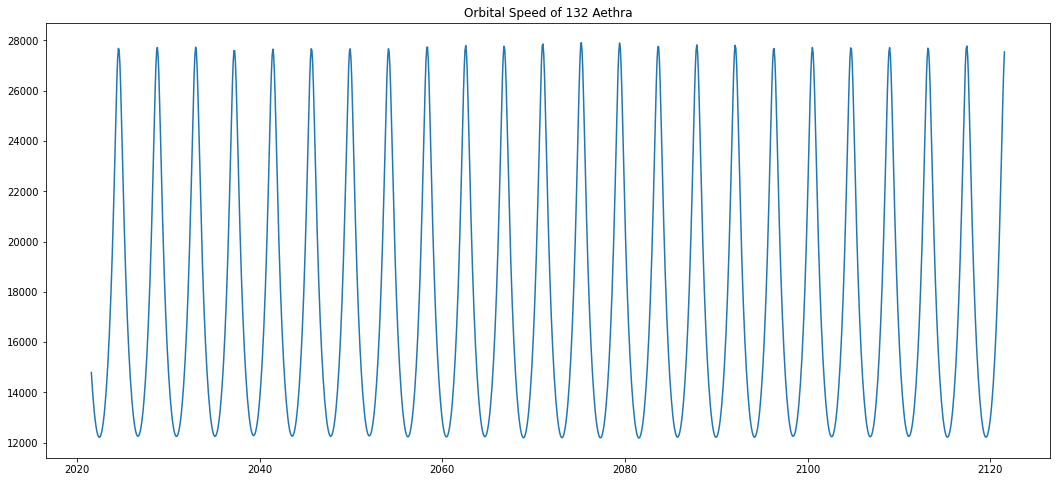

In [ ]:
velocity = np.stack([vecs['vx'], vecs['vy'], vecs['vz']]) * u.au / u.d
speed = np.linalg.norm(velocity, axis=0).to('m/s')

fig = plt.gcf()
fig.set_size_inches(18, 8)
plt.plot([x.to_datetime() for x in times], speed[:mars.shape[1]])
plt.title("Orbital Speed of 132 Aethra")

In [145]:
from astropy.units import Unit

GM_SUN = 1.32712440018e20 * Unit('meter') ** 3 / Unit('second') ** 2.0

grav_param = Unit('m**3/s**2')

# Gravitational constant value from CODATA 2018- the last 2 sig figs are uncertain
BIG_G = 6.67430e-11 * grav_param / 'kg'

In [ ]:
(np.array(1.32712440018e20) / np.array(6.67430e-11)) * np.array(6.67430e-11)

1.32712440018e+20

In [ ]:
pos = np.array([
    [0.0, 0.0, 0.0],
    [1.496e+11, 0.0, 0.0]
]) * Unit('m')
mass = np.array([1.989e30, 6.417e23]) * Unit('kg')

def compute_gravity(pos, mass) -> Quantity:
    diffs = pos - pos[..., None, :]         # [N, N, 3]
    dists = np.linalg.norm(diffs, axis=-1)  # [N, N]

    # Mask out non-existent gravitational attractions of objects to themselves, which would
    # otherwise cause a divide by zero error (since the distance is 0)
    np.fill_diagonal(dists, np.inf)
    return BIG_G * np.sum(mass[None, :, None] * diffs / dists[..., None] ** 3, axis=-2)  # [N, 3]

compute_gravity(pos, mass)

<Quantity [[ 1.91370317e-09,  0.00000000e+00,  0.00000000e+00],
           [-5.93167462e-03,  0.00000000e+00,  0.00000000e+00]] m / s2>

In [5]:
from astropy.units import Unit
from pathfinder import State
import numpy as np

system = np.stack([
    State.get_body('Sun'),
    State.get_body('Venus'),
    State.get_body('Earth'),
    State.get_body('Mars')
    # State.get_body('Jupiter')
])
system = State(system)
system.compute_gravity()

<Quantity [[-1.13233894e-08, -2.73879691e-08, -1.07050228e-08],
           [ 9.06867066e-03,  6.41819534e-03,  2.31412980e-03],
           [-3.84377872e-03,  3.93701769e-03,  1.70670256e-03],
           [ 2.07789398e-03, -4.53050424e-04, -2.63872296e-04]] m / s2>

In [14]:
import torch

SECS_PER_YEAR = 31_556_952
SECS_PER_WEEK = 604_800

result = system.evolve(torch.arange(0.0, SECS_PER_YEAR * 20, step=SECS_PER_WEEK))